In [1]:
%pylab inline

from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torch.autograd import Variable

# Torch introduction

(Py)Torch is a neural network package developed by Facebook, that is extremely simple. We'll use it to implement neural networks

# Torch tensor

Torch tensors are just like numpy arrays, but with a twist - they can also live on the GPU. Many methods are called similarly to numpy's, but unfortunately there are many API differences. See the documentation for supported functions: http://pytorch.org/docs/master/tensors.html.

In [3]:
# use torch.form_numpy to convert a numpy array. For CPU tensors, it is fast (no memory copy)

# Define 4 samples
X = torch.from_numpy(np.array([[0,0],
                               [0,1],
                               [1,0],
                               [1,1]], dtype=np.float32))
Y = torch.from_numpy(np.array([[0], [1],[1], [0]], dtype=np.float32))

In [4]:
print(X, Y)


 0  0
 0  1
 1  0
 1  1
[torch.FloatTensor of size 4x2]
 
 0
 1
 1
 0
[torch.FloatTensor of size 4x1]



Text(0.5,1,u'The XOR function')

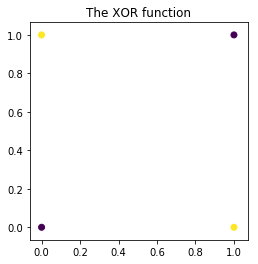

In [5]:
# Use tensor.numpy to turn a tensor into a numpy array - on CPU, this is fast (no memory copy)
scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy().ravel())
axis('square')
title('The XOR function')

In [16]:
# Define two neurons: an AND neuron, and an OR neuron
hW = torch.from_numpy(np.array([[1.0, 1.0],
                                [1.0, 1.0]], dtype=np.float32))
hb = torch.from_numpy(np.array([[-.5, -1.5]], dtype=np.float32))

print('hW: ', hW, 'hb: ', hb)

# compute the hidden activation, we multiply by 10. to have the sigmoid look like the step function
H = torch.sigmoid(100 * (X.matmul(hW) + hb))

print('H: ', H)

hW:  
 1  1
 1  1
[torch.FloatTensor of size 2x2]
 hb:  
-0.5000 -1.5000
[torch.FloatTensor of size 1x2]

H:  
 0.0000  0.0000
 1.0000  0.0000
 1.0000  0.0000
 1.0000  1.0000
[torch.FloatTensor of size 4x2]



In [23]:
# Define an output neuron (x1 OR x2) AND NOT (x1 AND x2)

oW = torch.from_numpy(np.array([[ 1.0], 
                                [-1.0]], dtype=np.float32))
ob = torch.from_numpy(np.array([[-0.5]], dtype=np.float32))

# compute the output, we multiply by 10. to have the sigmoid look like the step function
O = torch.sigmoid(100.0 * (H.matmul(oW) + ob))

print('O: ', O, 'Y: ', Y)

O:  
 1.9287e-22
 1.0000e+00
 1.0000e+00
 1.9287e-22
[torch.FloatTensor of size 4x1]
 Y:  
 0
 1
 1
 0
[torch.FloatTensor of size 4x1]



In [25]:
# Let's define a function

def net(X, hW, hb, oW, ob):
    H = torch.sigmoid(10.0 * (X.matmul(hW) + hb))
    O = torch.sigmoid(10.0 * (H.matmul(oW) + ob))
    return O

net(X, hW, hb, oW, ob)


 0.0072
 0.9924
 0.9924
 0.0072
[torch.FloatTensor of size 4x1]

In [26]:
X.cuda()


 0  0
 0  1
 1  0
 1  1
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

In [27]:
# CUDA computations
# Use .cuda() to move variable to the GPU

net(X.cuda(), hW.cuda(), hb.cuda(), oW.cuda(), ob.cuda())


 0.0072
 0.9924
 0.9924
 0.0072
[torch.cuda.FloatTensor of size 4x1 (GPU 0)]

# The Variable class know about gradients

In [28]:
XV = Variable(X.cuda(), requires_grad=False)

# .data holds the values
print("XV: ", XV)
print("XV.data: ", XV.data)

XV:  Variable containing:
 0  0
 0  1
 1  0
 1  1
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

XV.data:  
 0  0
 0  1
 1  0
 1  1
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]



In [29]:
XV = Variable(X, requires_grad=False)
YV = Variable(Y, requires_grad=False)

hWV = Variable(hW, requires_grad=True)
hbV = Variable(hb, requires_grad=True)
oWV = Variable(oW, requires_grad=True)
obV = Variable(ob, requires_grad=True)

# notice that out will also be a variable
out = net(XV, hWV, hbV, oWV, obV)
print ("out", out)

out Variable containing:
 0.0072
 0.9924
 0.9924
 0.0072
[torch.FloatTensor of size 4x1]



In [30]:
loss = ((out - YV)**2).sum()
loss

Variable containing:
1.00000e-04 *
  2.1919
[torch.FloatTensor of size 1]

In [31]:
loss.backward()

In [32]:
# .data holds the values
print("data: ", hWV.data)

# .grad holds the accumulated grdient, but 
print("grad: ", hWV.grad)

data:  
 1  1
 1  1
[torch.FloatTensor of size 2x2]

grad:  Variable containing:
1.00000e-05 *
 -7.7096  0.9561
 -7.7096  0.9561
[torch.FloatTensor of size 2x2]



In [33]:
# Training loop
# Depending on the initialization, this networks fails to train in about 10% cases.
# We'll explain why during next lecture.
params = [hWV, hbV, oWV, obV]

for p in params:
    p.data = torch.from_numpy(np.random.randn(*p.size()).astype('float32') * 0.1)

for step in range(3000):
    for p in params:
        # functions ending in _ modify the tensor!
        p.grad.data.zero_()
    out = net(XV, *params)
    loss = ((out - YV)**2).sum()
    if (step % 250) == 0:
        print(step, loss.data[0])
    loss.backward()
    for p in params:
        p.data -= 1e-2 * p.grad.data

0 1.30230009556
250 0.248610556126
500 0.0135626578704
750 0.006257802248
1000 0.00399778736755
1250 0.00291724829003
1500 0.00228852662258
1750 0.00187883758917
2000 0.00159139977768
2250 0.00137893657666
2500 0.00121567759197
2750 0.00108641514089


In [34]:
import pprint

pprint.pprint(zip ('hWV, hbV, oWV, obV'.split(), params))

[('hWV,',
  Variable containing:
 0.4769 -0.6519
 0.4772 -0.6535
[torch.FloatTensor of size 2x2]
),
 ('hbV,',
  Variable containing:
-0.7415  0.2595
[torch.FloatTensor of size 1x2]
),
 ('oWV,',
  Variable containing:
-1.0196
-0.9877
[torch.FloatTensor of size 2x1]
),
 ('obV', Variable containing:
 0.4962
[torch.FloatTensor of size 1x1]
)]


In [35]:
if 1:
    for p in params:
        # functions ending in _ modify the tensor!
        p.grad.data.zero_()
    out = net(XV, *params)
    loss = ((out - YV)**2).sum()

In [36]:
# Alt network - this one is easier to train and converges most of the time!
params = [hWV, hbV, oWV, obV]

def net2(X, hW, hb, oW, ob):
    H = torch.tanh(((X * 2.0 - 1.0).matmul(hW) + hb))
    O = torch.sigmoid((H.matmul(oW) + ob))
    return O

for p in params:
    p.data = torch.from_numpy(np.random.randn(*p.size()).astype('float32') * 0.1)

for step in range(3000):
    for p in params:
        # functions ending in _ modify the tensor!
        p.grad.data.zero_()
    out = net2(XV, *params)
    loss = ((out - YV)**2).sum()
    if (step % 250) == 0:
        print(step, loss.data[0])
    loss.backward()
    for p in params:
        p.data -= p.grad.data * 1e-1

0 1.00571060181
250 1.00000333786
500 0.999988973141
750 0.999966561794
1000 0.999856650829
1250 0.997202694416
1500 0.301792025566
1750 0.0391596369445
2000 0.0190621707588
2250 0.0123739829287
2500 0.00909661035985
2750 0.00716654770076
